# Calculating Quantum Processes
In this example we would like to calculate the error transfer matrices (quantum processes of the error channels) of a two-qubit gateset for singlet-triplet qubits subject to $1/f$-like charge noise that are manipulated via a detuning-controlled exchange interaction. The error transfer matrix is here understood as the Liouville representation of the ensemble averaged error superpropagator $\langle\tilde{\mathcal{U}}(\tau)\rangle$. It is completely characterized by the cumulant function,

$$
\langle\mathcal{\tilde{U}}(\tau)\rangle = \exp\mathcal{K}(\tau),
$$

where $\mathcal{K}(\tau)$ is a $d^2\times d^2$ matrix ($d$ being the dimension of the quantum system) expressed in a basis of orthonormal Hermitian matrices $\mathcal{C}=\{C_i\}_{i=0}^{d^2-1}$. It captures the deviation from the identity channel and can be used to extract many useful quantities that describe the channel. For instance, the entanglement infidelity of the pulse is given by

$$
\mathcal{I}_\mathrm{e} = 1 - \frac{1}{d^2}\mathrm{tr}\,\langle\tilde{\mathcal{U}}(\tau)\rangle \approx -\mathrm{tr}\,\mathcal{K}(\tau),
$$

where the approximation holds for small noise, and the state fidelity (probability that a state is returned to itself) for pure input states by

$$
p_{j\rightarrow j} = \langle\!\langle\rho_j\rvert\mathcal{Q}\langle\mathcal{\tilde{U}}\rangle\lvert\rho_j\rangle\!\rangle
$$

with $\lvert\rho_j\rangle\!\rangle = \sum_{k=0}^{d^2-1}\mathrm{tr}(C_k\rho_j)\lvert k\rangle\!\rangle$ the vectorized density matrix in the basis $\mathcal{C}$ and $\mathcal{Q}$ the Liouville representation of the total propagator $Q$ of the control pulse.

Within `filter_functions`, the cumulant function $\mathcal{K}(\tau)$ is calculated from first-order Magnus expansion terms alone.  These terms induce dissipation. Additional second-order terms, inducing coherent errors, can be neglected if we assume that the experimentalist has calibrated their pulses. For Gaussian noise, higher orders cancel out and the above expressions are exact. In the case of non-Gaussian noise, they become peturbative in the noise parameter $\xi$, being of order $\xi^2$.

Again we use the optimized gates presented in [Cerfontaine et al. (2019)] and start by loading the data and setting up the control operators $A_i$.

[Cerfontaine et al. (2019)]: https://arxiv.org/abs/1901.00851

In [1]:
import sys
from pathlib import Path

import numpy as np
from qutip.qip import operations
from qutip.visualization import matrix_histogram
from scipy import io

import filter_functions as ff
from filter_functions import numeric, util

In [2]:
# use widget for interactive mode
%matplotlib inline

In [3]:
data_path = Path(ff.__file__).parent.parent / 'examples/data'
if not data_path.exists():
    # RTD build
    data_path = Path('../../../examples/data')

In [4]:
gates = ['X2ID', 'Y2ID', 'CNOT']
struct = {'X2ID': io.loadmat(str(data_path / 'X2ID.mat')),
          'Y2ID': io.loadmat(str(data_path / 'Y2ID.mat')),
          'CNOT': io.loadmat(str(data_path / 'CNOT.mat'))}
eps = {key: np.asarray(struct[key]['eps'], order='C') for key in gates}
dt = {key: np.asarray(struct[key]['t'].ravel(), order='C') for key in gates}
B = {key: np.asarray(struct[key]['B'].ravel(), order='C') for key in gates}
B_avg = {key: struct[key]['BAvg'].ravel() for key in gates}
infid_fast = {key: struct[key]['infid_fast'].ravel() for key in gates}
# B_avg same for all
B_avg = B_avg['X2ID']
T = {key: val.sum() for key, val in dt.items()}

J = {key: np.exp(eps[key]) for key in gates}
n_dt = {key: len(dt[key]) for key in gates}

d = 16
H = np.empty((6, d, d), dtype=complex)

Id, Px, Py, Pz = util.paulis
# Exchange Hamiltonians
H[0] = 1/4*sum(util.tensor(P, P, Id, Id) for P in (Px, Py, Pz))
H[1] = 1/4*sum(util.tensor(Id, P, P, Id) for P in (Px, Py, Pz))
H[2] = 1/4*sum(util.tensor(Id, Id, P, P) for P in (Px, Py, Pz))
# Zeeman Hamiltonians
H[3] = 1/8*(util.tensor(Pz, Id, Id, Id)*(-3) +
            util.tensor(Id, Pz, Id, Id) +
            util.tensor(Id, Id, Pz, Id) +
            util.tensor(Id, Id, Id, Pz))
H[4] = 1/4*(util.tensor(Pz, Id, Id, Id)*(-1) +
            util.tensor(Id, Pz, Id, Id)*(-1) +
            util.tensor(Id, Id, Pz, Id) +
            util.tensor(Id, Id, Id, Pz))
H[5] = 1/8*(util.tensor(Pz, Id, Id, Id)*(-1) +
            util.tensor(Id, Pz, Id, Id)*(-1) +
            util.tensor(Id, Id, Pz, Id)*(-1) +
            util.tensor(Id, Id, Id, Pz)*3)

# Technically there would also be H_0 (the mean magnetic field), but on the
# m_s = 0 subspace it is zero.

## Defining a custom basis
Because we are interested in the fidelity of the two-qubit gates that live on the $4\times 4$ subspace of the complete $16$-dimensional Hilbert space, we single out the $6\times 6$ subspace with magnetic spin quantum number $m_s = 0$ in which the qubits are encoded. We have to include the leakage levels $\bigl\lbrace\lvert\downarrow\downarrow\uparrow\uparrow\rangle, \lvert\uparrow\uparrow\downarrow\downarrow\rangle\bigr\rbrace$ as they are accessible via the intermediate exchange interaction $J(\epsilon_{23})$ during the gate sequence.

In [5]:
opers = list(H)

# Reduce to 6x6 subspace
zerospin_subspace_inds = ((3, 5, 6, 9, 10, 12), (3, 5, 6, 9, 10, 12))
d_zerospin_subspace = 6
opers = [H[np.ix_(*zerospin_subspace_inds)] for H in H]

# Subtract identity to make Hamiltonian traceless (always allowed since we are
# not interested in absolute energies)
opers = [oper - np.trace(oper)/d_zerospin_subspace*np.eye(d_zerospin_subspace)
         for oper in opers]

# The coefficients are the exchange couplings and B-field gradients
c_coeffs = {key: [J[key][0],
                  J[key][1],
                  J[key][2],
                  B[key][0]*np.ones(n_dt[key]),
                  B[key][1]*np.ones(n_dt[key]),
                  B[key][2]*np.ones(n_dt[key])] for key in gates}
# We include the exponential dependence of J on epsilon by a first-order
# derivative (just J back) as noise sensitivity.
n_coeffs = {key: [J[key][0],
                  J[key][1],
                  J[key][2],
                  np.ones(n_dt[key]),
                  np.ones(n_dt[key]),
                  np.ones(n_dt[key])] for key in gates}

identifiers = ['J_12', 'J_23', 'J_34', 'B_12', 'B_23', 'B_34']

H_c = {key: list(zip(opers, val, identifiers))
       for key, val in c_coeffs.items()}
H_n = {key: list(zip(opers, val, identifiers))
       for key, val in n_coeffs.items()}

In order to be able to distinguish the qubit subspace from the leakage subspace, we define a basis that exclusively has elements that only live on either by padding a two-qubit Pauli basis with zeros on the leakage subspace and letting the ``Basis`` constructor fill up the basis so that it is orthonormal and complete on the entire space.

In [6]:
# Leakage levels are at indices 0 and 5 of the 6x6 Hamiltonian
qubit_subspace_inds = ((1, 2, 3, 4), (1, 2, 3, 4))

subspace_basis = ff.Basis.pauli(2)
basis = ff.Basis.from_partial([np.pad(b, 1, 'constant')
                               for b in subspace_basis],
                              labels=subspace_basis.labels)

print('Basis orthonormal:', basis.isorthonorm)
print('Basis complete:', basis.iscomplete)
# Print one element as an example
print(f'Padded {basis.labels[1]}:\n', basis[1].real)

Basis orthonormal: True
Basis complete: True
Padded IX:
 [[0.  0.  0.  0.  0.  0. ]
 [0.  0.  0.5 0.  0.  0. ]
 [0.  0.5 0.  0.  0.  0. ]
 [0.  0.  0.  0.  0.5 0. ]
 [0.  0.  0.  0.5 0.  0. ]
 [0.  0.  0.  0.  0.  0. ]]


Now we can initialize the `PulseSequence` instances and diagonalize them to verify they give rise to the correct gates:

In [7]:
# Initialize the PulseSequences
pulses = {
    gate: ff.PulseSequence(H_c[gate], H_n[gate], dt[gate], basis=basis)
    for gate in gates
}

# Target gates
U_t = {
    'X2ID': util.tensor((Id - 1j*Px)/np.sqrt(2), Id),    # sqrt X
    'Y2ID': util.tensor((Id - 1j*Py)/np.sqrt(2), Id),    # sqrt Y
    'CNOT': operations.cnot()
}

Correct action of the gates:
----------------------------
X2ID	True
Y2ID	True
CNOT	True


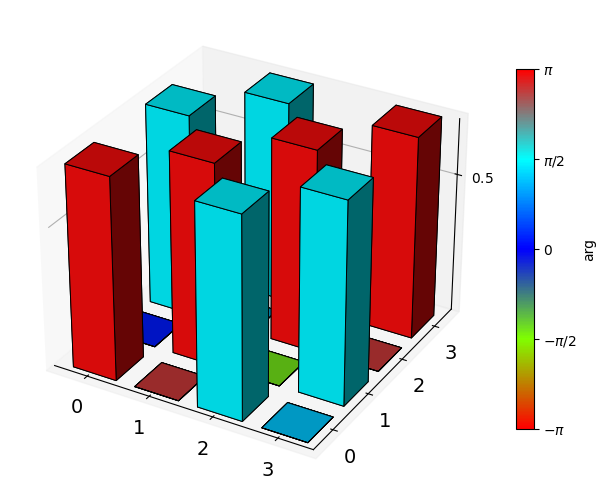

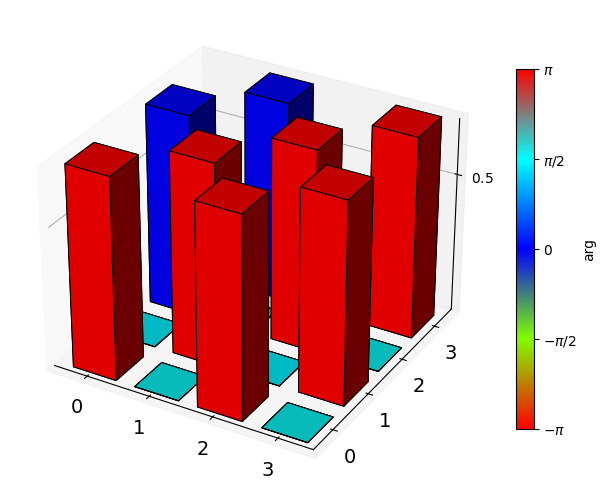

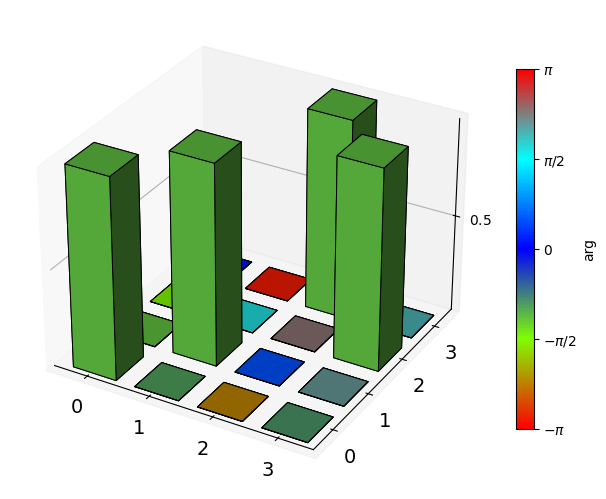

In [8]:
print('Correct action of the gates:')
print('----------------------------')
for key, pulse in pulses.items():
    pulse.diagonalize()
    # Reduce to qubit subspace
    U = pulse.total_propagator[np.ix_(*qubit_subspace_inds)]
    # Plot the propagator
    matrix_histogram(U, bar_style='abs', color_style='phase')
    # Check for equality with the target unitary up to global phase
    print(key, util.oper_equiv(U_t[key], U, eps=1e-9)[0], sep='\t')

## Noise power spectral density
Now that we have verified that our pulses do what they are supposed to, we can turn to calculating the error transfer matrix given a noise spectrum. As a quick reminder, the noise power spectral density $S_\alpha(\omega)$ is defined as the Fourier transform of the autocorrelation function of the noise variable $b_\alpha(t)$. For *wide-sense stationary* noise the autocorrelation only depends on the time difference and we have

$$
    \langle b_\alpha(t_1)b_\alpha(t_2)\rangle = \int_{-\infty}^\infty\frac{\mathrm{d}\omega}{2\pi}S_\alpha(\omega)e^{-i\omega(t_1 - t_2)}
$$

where $S_\alpha(\omega)$ is the two-sided power spectral density for noise source $\alpha$. Since the spectrum is classical, it is symmetric about $\omega=0$ (corresponding to equal rates of excitation from and emission to the environment). We can therefore consider only positive frequencies. 

Here we use $1/f$-like noise with a one-sided spectrum of

$$
    S_\epsilon(f) = A f^{-0.7}, \quad S_\epsilon(f=1\,\text{MHz}) = 4\times 10^{-20}\,\text{V}^2/\text{Hz}
$$

as reported by [Dial et al. (2013)].

[Dial et al. (2013)]: https://doi.org/10.1103/PhysRevLett.110.146804

In [9]:
# Voltages are in units of eps0 and energies in units of inverse nanoseconds
# (see Cerfontaine et al. (2019))
eps0 = 2.7241e-4
alpha = 0.7
# S(f) = A f^{-\alpha}
# At f = 1 MHz = 1e-3 GHz, S = S_0 = 4e-20 V^2/Hz = 4e-11/eps0^2 1/GHz
# Correspondingly, S(\omega) = A \omega^{-\alpha} such that at
# \omega = 2\pi 10^{-3} GHz, S_0 = 4e-11/eps0^2 1/GHz
S_0 = 4e-11/eps0**2
A = S_0*(2*np.pi*1e-3)**alpha

## Error transfer matrices
We are now ready to calculate the error transfer matrix $\langle\tilde{\mathcal{U}}(\tau)\rangle$. Since it is completely characterized by the cumulant function $\mathcal{K}_\epsilon(\tau)$, we will deal with the latter. This has the advantage that we can inspect contributions from different noise sources separately. Because the error transfer matrix is given by the exponential of $\mathcal{K}(\tau)$, contributions from different noise operators will mix due to non-commutativity and a separate discussion of the contributions will neglect terms of order $\xi^4$.

The cumulant function for Gaussian noise sources $(\alpha,\beta)$ is given by

$$
\mathcal{K}_{\alpha\beta}(\tau) = -\frac{1}{2}\sum_{kl}(f_{ijkl}\Delta_{\alpha\beta,kl} + g_{ijkl}\Gamma_{\alpha\beta,kl})
$$

where $f,g$ are trivial functions of the trace tensor $T$ and $\Gamma$ $(\Delta)$ are the decay amplitudes (frequency shifts) capturing decoherence (unitary errors). The decay amplitudes (frequency shifts) are computed from the first (second) order of the Magnus expansion and most of our discussion deals with the former. This is because unitary errors can usually be calibrated out to a large degree and furthermore do not contribute to experimentally accessible quantities like the gate fidelity to leading order.

The decay amplitudes $\Gamma$ can be calculated from the generalized filter function and are thus amenable to the concatenation property of the control matrices. As the second order of the Magnus expansion involves a double time integral, such a simplification is not possible in the case of the frequency shifts $\Delta$. However, we can define a filter function for them just the same:

\begin{align}
\Gamma_{\alpha\beta,kl} &= \int\frac{\mathrm{d}\omega}{2\pi}S_{\alpha\beta}(\omega) F_{\alpha\beta,kl}^{(\Gamma)}(\omega) \\
\Delta_{\alpha\beta,kl} &= \int\frac{\mathrm{d}\omega}{2\pi}S_{\alpha\beta}(\omega) F_{\alpha\beta,kl}^{(\Delta)}(\omega)
\end{align}

### Performance considerations
For the computation of the error transfer matrix it is beneficial for the basis used to be sparse since the elements of the matrix are sums of terms proportional to traces of four basis elements of the form $\mathrm{tr}(C_i C_j C_k C_l)$. These traces are inherently mostly zero since the basis elements form an orthonormal set. If the elements themselves are sparse, the entire calculation can be performed quite efficiently. The Generalized Gell-Mann bases are sparse bases as most of their elements only have two non-zero entries. The Pauli bases have filling factor $1/2$ on the other hand and thus take longer to compute.

Since the traces are cached, this only applies for the first time the error transfer matrix is computed.

### Calculation using `filter_functions`
The calculation is implemented in the `numeric.calculate_cumulant_function()` function, which takes a `PulseSequence` instance, a noise spectrum and a list of frequencies as arguments. Optionally, we may also pass a list of identifiers corresponding to the noise operators whose contributions we are interested in. In our case we use the exchange terms affected by charge noise. The function will return an array with the separate noise operator contributions on the first axis. Visualization of the cumulant function is implemented by ``plotting.plot_cumulant_function()``.

Calculating control matrix:   0%|          | 0/100 [00:00<?, ?it/s]

Calculating second order FF:   0%|          | 0/100 [00:00<?, ?it/s]

Calculating control matrix:   0%|          | 0/100 [00:00<?, ?it/s]

Calculating second order FF:   0%|          | 0/100 [00:00<?, ?it/s]

Calculating control matrix:   0%|          | 0/250 [00:00<?, ?it/s]

Calculating second order FF:   0%|          | 0/250 [00:00<?, ?it/s]

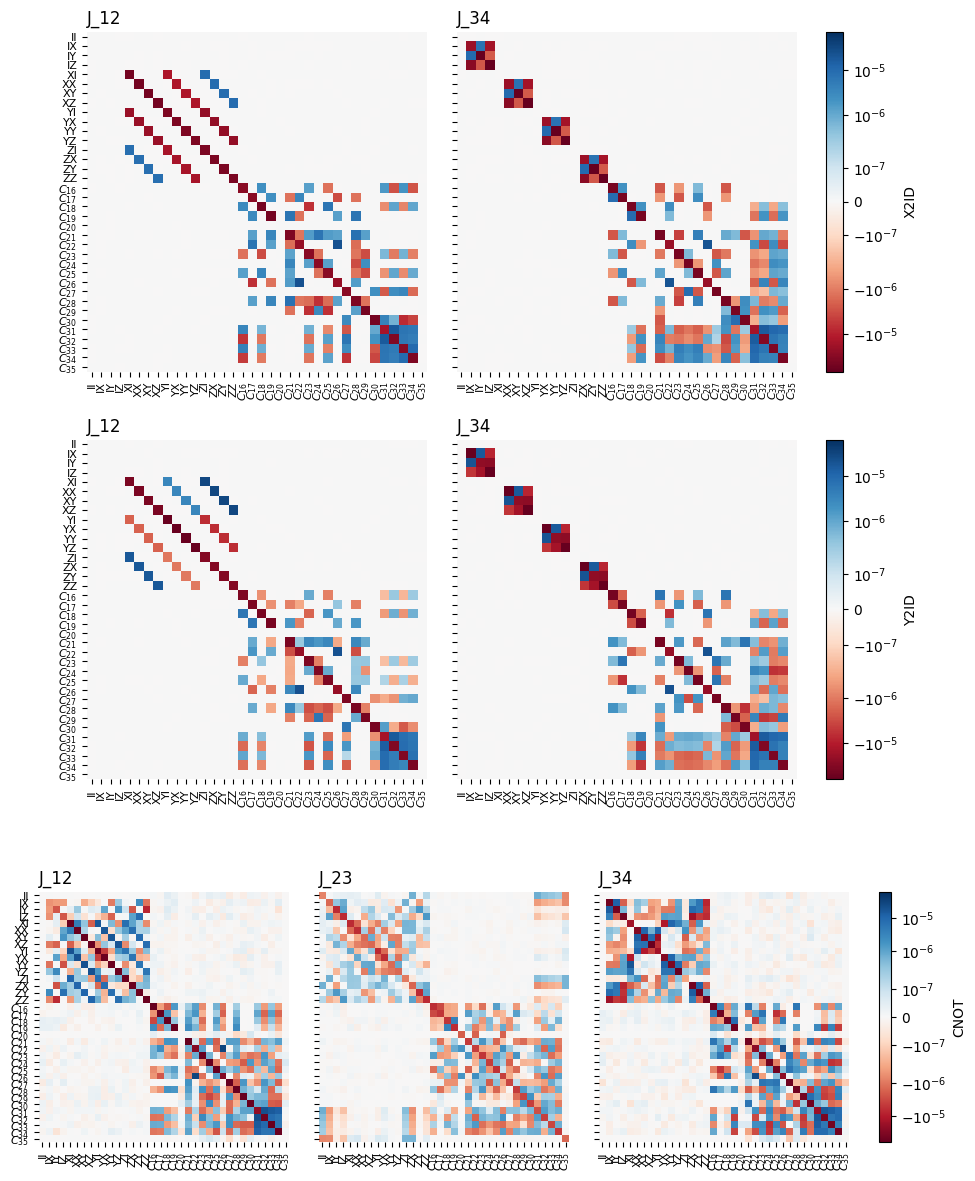

In [10]:
from itertools import product
import matplotlib.pyplot as plt
from filter_functions import plotting

fig = plt.figure(figsize=(11, 15))

cumulant_functions = {}
for i, (key, pulse) in enumerate(pulses.items(), 1):
    omega = np.geomspace(1/T[key], 1e2, 400)
    spectrum = A/omega**alpha

    if key == 'CNOT':
        identifiers = ['J_12', 'J_23', 'J_34']
    else:
        # For single qubit pulses intermediate exchange is turned off
        identifiers = ['J_12', 'J_34']
        
    cumulant_functions[key] = numeric.calculate_cumulant_function(
        pulse, spectrum, omega, n_oper_identifiers=identifiers,
        show_progressbar=True, second_order=True
    )

    # We can call plot_cumulant_function with the same arguments as
    # error_transfer_matrix in which case the transfer matrix is calculated on
    # the fly, or pass a pre-computed transfer matrix to the function
    fig, grid = plotting.plot_cumulant_function(
        pulse, cumulant_function=cumulant_functions[key],
        n_oper_identifiers=identifiers, grid_kw=dict(rect=10*31+i),
        figsize=(11, 4), fig=fig, cbar_label=key, colorscale='log'
    )
    
plt.show()

As we can see, for the single-qubit gates the computational and leakage subspaces are sufficiently decoupled and the structure of the error transfer matrix reveals a nice symmetry of noise processes on the two qubits. For the CNOT, this symmetry is not as pronounced and the error transfer matrix for the intermediate exchange $J_{23}$ mixes the computational and leakage subspaces to a small degree.

## Deriving quantities
With the cumulant function calculated, we can now derive different quantities from the error transfer matrix $\langle\tilde{\mathcal{U}}\rangle = \exp\mathcal{K}$. Here we take a look at the state fidelity of the computational basis states for the CNOT gate and the entanglement fidelities of the gates.

### State fidelity
The state fidelity is given by (see above)

$$
p_{j\rightarrow j} = \langle\!\langle\rho_j\rvert\mathcal{Q}\langle\mathcal{\tilde{U}}\rangle\lvert\rho_j\rangle\!\rangle.
$$

We can calculate the vectorized density matrices $\lvert\rho_j\rangle\!\rangle$ using `ff.basis.expand()` and the Liouville representation of the total propagator of the pulse using `ff.liouville_representation()`.

In [11]:
# ff.error_transfer_matrix can also be called with a PulseSequence, spectrum
# and list of frequencies to compute the error transfer matrix directly instead
# of from a cumulant function
transfer_matrices = {gate: ff.error_transfer_matrix(cumulant_function=K)
                     for gate, K in cumulant_functions.items()}

pulse = pulses['CNOT']
basis = pulse.basis
# Also exists as pulse.total_propagator_liouville
total_propagator_liouville = ff.liouville_representation(pulse.total_propagator, basis)
# Sum up the individual noise operator contributions for simplicity
U_tilde = transfer_matrices['CNOT']
ket_00, ket_01, ket_10, ket_11 = np.zeros((4, 6, 1))
ket_00[1] = 1
ket_01[2] = 1
ket_10[3] = 1
ket_11[4] = 1
rhoket_00 = ff.basis.expand(np.outer(ket_00, ket_00), basis, hermitian=True)
rhoket_01 = ff.basis.expand(np.outer(ket_01, ket_01), basis, hermitian=True)
rhoket_10 = ff.basis.expand(np.outer(ket_10, ket_10), basis, hermitian=True)
rhoket_11 = ff.basis.expand(np.outer(ket_11, ket_11), basis, hermitian=True)
rhokets = (rhoket_00, rhoket_01, rhoket_10, rhoket_11)
labels = ('00', '01', '10', '11')

for label, rhoket in zip(labels, rhokets):
    F = rhoket.T @ total_propagator_liouville @ U_tilde @ rhoket
    print('p({l}->{l}) = {v:.4e}'.format(l=label, v=F.real))

p(00->00) = 9.9992e-01
p(01->01) = 9.9992e-01
p(10->10) = 2.3184e-05
p(11->11) = 2.3184e-05


The probabilities are not exactly one and zero but differ from the target outcome by $\sim 10^{-5}$ due to the influence of the noise.

### Entanglement fidelity <a id='fidelity'></a>
The entanglement fidelity is given by (see above)

$$
\mathcal{I}_\mathrm{e} = 1 - \frac{1}{d^2}\mathrm{tr}\,\langle\mathcal{\tilde{U}}\rangle.
$$

We are only interested in the dynamics on the qubit subspace and thus do not care about contributions from basis elements on the leakage subspace, so that we only trace over the first 16 elements of the error transfer matrix. We will compare the results to the Monte Carlo results for fast noise from the reference.

Because the fidelity is an often-employed figure of merit, its calculation is also implemented in a separate function, `ff.infidelity()`, that is much faster than deriving the fidelity from the error transfer matrix because it only calculates the leading order approximation. Its interface is very similiar to that of `ff.error_transfer_matrix()` and is thus not discussed here. Only note that some subtleties apply if calculating the fidelity in the presence of leakage levels.

In [12]:
print('Gate', 'Transfer Matrix', 'Monte Carlo', 'Relative deviation', sep='\t')
print('----------------------------------------------------------')
for key, pulse in pulses.items():
    infidelity = 1 - abs(transfer_matrices[key][:16, :16].trace())/4**2
    rel_div = (infidelity.sum() - infid_fast[key][1])/infid_fast[key][1]
    print(key,
          '{:.2e}'.format(infidelity.sum()),
          '{:.2e}'.format(infid_fast[key][1]),
          '{:.1e}'.format(rel_div),
          sep='\t')

Gate	Transfer Matrix	Monte Carlo	Relative deviation
----------------------------------------------------------
X2ID	7.08e-05	7.17e-05	-1.3e-02
Y2ID	6.95e-05	7.03e-05	-1.2e-02
CNOT	7.84e-05	7.89e-05	-6.9e-03


## Complete positivity
For a map $\mathcal{U}:\rho\rightarrow\mathcal{U}(\rho)\equiv\rho'$ to be physical, i.e. map density operators to density operators, it needs to be completely positive (CP). Mathematically, this is given iff

$$
    \text{choi}(\mathcal{U}) \geq 0
$$

with $\text{choi}(\mathcal{U}) = (\mathcal{U}\otimes\mathbb{I})(|\Omega\rangle\langle\Omega|)$ the Choi matrix representation of the map $\mathcal{U}$ and $|\Omega\rangle$ any maximally entangled state. This is known as the Choi-Jamiołkowski isomorphism of quantum channels and states. As can be shown, the error transfer matrix $\langle\mathcal{\tilde{U}}\rangle = \exp\mathcal{K}$ is CP, and thus constitutes a valid quantum operation, when taking the decay amplitudes $\Gamma$ and/or frequency shifts $\Delta$ into account for the cumulant function. However, when approximating $\langle\mathcal{\tilde{U}}\rangle\approx\mathbb{1} + \mathcal{K}$, this need in general not be true anymore. Since simplified expressions for derived quantites, as discussed above, can be obtained in the approximation, complete positivity (or the degree of violation thereof) of the approximated map can hence - in addition to convergence and smallness criteria for the perturbative expansion - serve as a figure of merit of the approximation.

Functions related to this topic are collected in the `superoperator` module. For instance, we can check if $\langle\mathcal{\tilde{U}}\rangle$ is CP using `superoperator.liouville_is_CP` as follows.

In [13]:
from filter_functions import superoperator

for key, pulse in pulses.items():
    print('----', key, '----', sep='\n')
    # CP is boolean, D and V are eigenvalues and -vectors of the Choi matrix
    CP, (D, V) = superoperator.liouville_is_CP(transfer_matrices[key],
                                               pulse.basis, return_eig=True)
    print(f'Error transfer matrix CP: {CP}')  # all(D >= 0) up to floating point error
    print(f'Smallest Choi eigenvalue: {np.min(D):.2e}')
    
    # Check CPness of approximation:
    approximation = np.eye(pulse.d**2) + cumulant_functions[key].sum(0)
    CP, (D, V) = superoperator.liouville_is_CP(approximation, pulse.basis,
                                               return_eig=True)
    print(f'Approximate error transfer matrix CP: {CP}')
    print(f'Smallest Choi eigenvalue: {np.min(D):.2e}')

----
X2ID
----
Error transfer matrix CP: True
Smallest Choi eigenvalue: -7.45e-16
Approximate error transfer matrix CP: True
Smallest Choi eigenvalue: -1.04e-15
----
Y2ID
----
Error transfer matrix CP: True
Smallest Choi eigenvalue: -6.23e-16
Approximate error transfer matrix CP: True
Smallest Choi eigenvalue: -1.40e-15
----
CNOT
----
Error transfer matrix CP: True
Smallest Choi eigenvalue: 2.09e-13
Approximate error transfer matrix CP: True
Smallest Choi eigenvalue: 4.97e-15


## Convergence of the frequency integral
Since we are integrating numerically, we should also perform a convergence test in order to see if the frequency resolution is large enough. This is also implemented in `ff.infidelity()`. In this case, the function arguments `S` and `omega` take on a different meaning; `spectrum` should be a `Callable` function handle for computing the spectrum from a list of frequencies, and `omega` should be a dictionary with entries defining the boundary conditions for the convergence test, e.g. the minimum and maximum number of frequency points $n_\omega$ for the convergence test. For brevity, we only show the convergence for the CNOT.

(11, 6)


Text(0.5, 0.98, 'CNOT convergence')

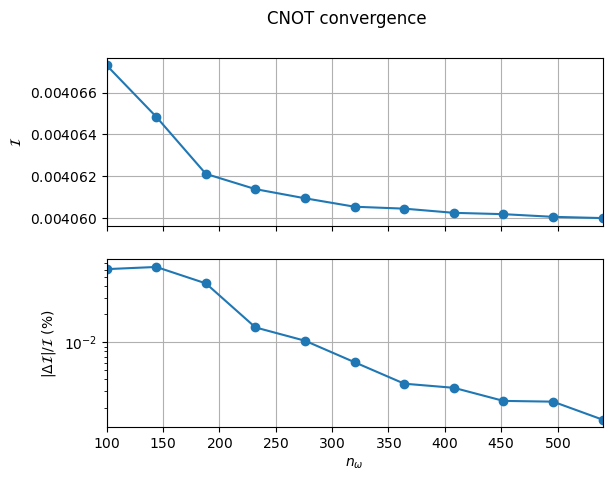

In [14]:
def spectrum(omega): return A/omega**alpha

# Define the boundary conditions (all of these values also have sensible
# defaults)
omega = {
    'omega_IR': 1e-2/T['CNOT'],
    'omega_IV': 100,
    'spacing': 'log',
    'n_min': 100,
    'n_max': 500,
    'n_points': 10
}

n_omega, infids = ff.infidelity(pulses['CNOT'], spectrum, omega,
                                test_convergence=True)
print(infids.shape)
fig, ax = plotting.plot_infidelity_convergence(n_omega, infids.sum(axis=1))
fig.suptitle('CNOT convergence')

As we can see, the integral converges for around $n_\omega = 300$ already. Note that the value of the infidelity here is not consistent with the one computed in [the section above](#fidelity) since `ff.infidelity()` computes the infidelity of the pulse on the complete Hilbert space, not only the computational subspace. Concretely, `ff.infidelity()` computes `transfer_matrices['CNOT'].trace()/6**2`.